In [36]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

from keras.models import load_model

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Step 1. 데이터 수집하기
이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.
추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습해보겠습니다.

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

data.sample(10)

,headlines,text
60634,"Home Minister urges Gates to adopt 1,000 Maois...",Home Minister Rajnath Singh on Thursday urged ...
45591,Govt clears bill to seize assets of defaulters...,The Union Cabinet has cleared a bill allowing ...
3653,PewDiePie fan who hacked 50k printers hacks Go...,Online handle 'TheHackerGiraffe' has claimed t...
13736,Alok Nath was once caught peeing in open: Hima...,"Actress Himani Shivpuri, who worked with rape-..."
47961,DND Flyway to remain toll free after SC postpo...,The Supreme Court on Tuesday said that the Del...
36900,Umpire didn't need to get involved in Kohli-Pa...,Ex-Australia captain Ricky Ponting has said um...
27119,UP govt to spend Ã¢ÂÂ¹2 crore for building co...,The Uttar Pradesh government will spend Ã¢ÂÂ¹...
76875,Usher to be sued by three people over herpes c...,"According to reports, singer Usher will be sue..."
7409,BJP can fight Naxals like Lord Rama fought dem...,Uttar Pradesh CM Yogi Adityanath on Wednesday ...
3696,Iran plans to ban Instagram over 'national sec...,Iran is planning to ban photo-sharing app Inst...


---
## Step 2. 데이터 전처리하기 (추상적 요약)

### 중복 샘플 제거
우선 `drop_duplicates()`을 사용하여 중복 샘플을 제거합니다.

In [3]:
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [4]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [5]:
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


In [6]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 텍스트 정규화와 불용어 제거
아래와 같이 dictionary를 구성하여 학습 전에 미리 같은 표현으로 통일시켜줍니다. 이러한 정규화를 통해 학습을 좀 더 정확하고 효율적이게 할 수 있습니다.

In [7]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120



- **불용어(stopwords)**: 일반적으로 텍스트에는 자주 등장하지만 자연어 처리를 할 때 실질적으로 별 도움이 되지 않는 단어들



In [8]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [9]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() 
    sentence = BeautifulSoup(sentence, "lxml").text 
    sentence = re.sub(r'\([^)]*\)', '', sentence) 
    sentence = re.sub('"','', sentence) 
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) 
    sentence = re.sub(r"'s\b","", sentence) 
    sentence = re.sub("[^a-zA-Z]", " ", sentence) 
    sentence = re.sub('[m]{2,}', 'mm', sentence)
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

### 텍스트 전처리

텍스트 정규화와 불용어 제거 등을 수행하는 `preprocess_sentence`함수를 만들어줍니다. 아래와 같은 작업을 수행합니다.

- 텍스트 소문자화
- `<br />`, `<a href = ...>` 등의 html 태그 제거
- 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
- 쌍따옴표 " 제거
- 만들어둔 약어 dictionary를 통해 약어 **정규화**
- 소유격 제거. Ex) roland's -> roland
- 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
- m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
- **불용어 제거**

이때 불용어의 제거 여부는 `remove_stopwords`인자를 통해 결정하게 됩니다.<br>
이렇게 하여 본문인 text에서는 불용어를 제거하고 요약인 headlines에서는 불용어를 제거하지 않도록 하겠습니다.

In [10]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_headlines, False))

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


In [11]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [12]:
clean_headlines = []
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


데이터 정제 과정에서 문장의 모든 단어가 사라지는 경우가 있을 수 있으므로 확인해 줍니다.<br>
해당 경우의 값들은 사용하지 않으니 제거해줍니다.

In [13]:
data['Text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

data.isnull().sum()

headlines    0
text         0
Text         0
dtype: int64

In [14]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 샘플의 최대 길이 정하기
학습에 사용될 데이터의 길이는 일정해야 합니다. 적절한 최대 길이를 다음과 같은 과정을 통해 구해봅니다.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 91
텍스트의 평균 길이 : 58.23813542090281
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


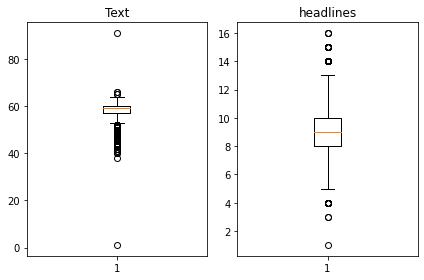

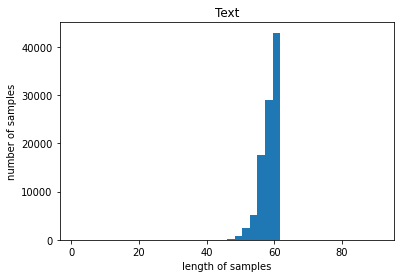

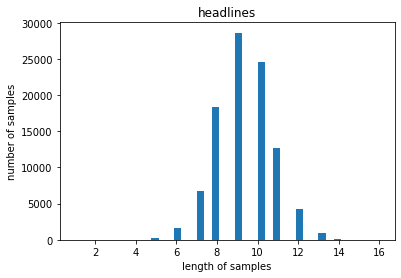

In [15]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [16]:
text_max_len = 60
headlines_max_len = 13

In [17]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [18]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len, data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 0.997448149654331
전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9981699877999186


임의로 text의 최대길이를 60, headlines의 최대길이를 13로 지정하였을 때 대부분의 샘플을 포함할 수 있는 것을 확인할 수 있습니다.<br>

### 시작 토큰과 종료 토큰 추가하기
디코더는 시작 토큰을 입력받아 문장을 생성하기 시작하고, 종료 토큰을 예측한 순간에 문장 생성을 멈추는 과정을 수행합니다.<br>
시작 토큰은 `sostoken`, 종료 토큰은 `eostoken`이라 임의로 명하고 샘플 앞, 뒤로 추가해 줍니다.
- `decoder_input`: 디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장
- `decoder_target`: 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장


In [19]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,Text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,Kunal Shah's credit card bill payment platform...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,New Zealand defeated India by 8 wickets in the...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer...",aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,Speaking about the sexual harassment allegatio...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [20]:
#인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장합니다.
encoder_input = np.array(data['text']) 
decoder_input = np.array(data['decoder_input'])
decoder_target = np.array(data['decoder_target'])

### 훈련 데이터와 테스트 데이터 분리

indices라는 랜덤 정수 시퀀스를 만들어 데이터를 무작위 순서로 섞습니다.<br>
이후 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리해 줍니다.

In [21]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

n_of_val = int(len(encoder_input)*0.2) # 8:2 분리
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19672


In [22]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


### 정수 인코딩
텍스트를 모델에 학습시키기 위해서는 정수로 만들어야 합니다.
Keras의 토크나이저를 사용하여 텍스트를 정수로 쉽게 변환할 수 있습니다.

In [23]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

위와 같이 입력된 `encoder_input_train`데이터로부터 단어 집합을 생성합니다.<br>
생성된 단어들은 토크나이저에 저장되는데 빈도수가 낮은 데이터들은 제외를 하겠습니다.

In [24]:
threshold = 7 #임의의 값
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 91180
등장 빈도가 6번 이하인 희귀 단어의 수: 66421
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 24759
단어 집합에서 희귀 단어의 비율: 72.84601886378593
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 2.728040014637005


등장 빈도가 threshold 값인 7회 미만, 즉 6회 이하인 단어들은 단어 집합에서 72% 이상을 차지합니다.<br>
하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 약 2.7%밖에 되지 않습니다.<br>
따라서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하겠습니다.

In [25]:
src_vocab = 24000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 24,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [26]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[4, 3, 132, 11, 8, 848, 968, 77, 444, 149, 2740, 12, 261, 1632, 17, 5668, 6, 10632, 3, 138, 21504, 12851, 22, 3, 274, 464, 4, 11331, 10632, 1, 12851, 3641, 4, 30, 14981, 75, 2061, 163, 1, 150, 536, 9, 164, 104, 7315, 401, 10, 7615, 1330, 1, 775, 16, 444, 6331, 2, 1856, 24, 1333, 47, 2740], [676, 2, 110, 39, 1891, 1196, 7919, 5829, 9014, 601, 1238, 1380, 12495, 1369, 5621, 22986, 64, 1, 39, 130, 1185, 298, 166, 7, 119, 3, 322, 139, 35, 2100, 144, 112, 1128, 109, 1260, 432, 632, 1498, 9493, 311, 6, 7616, 44, 12852, 67, 21, 126, 2, 1266, 7219, 5209, 90, 35, 16105, 194, 93, 3, 727, 249, 322, 159], [104, 876, 4189, 1306, 3059, 7, 140, 506, 2, 830, 2, 1, 41, 9, 951, 6, 2218, 7, 17, 80, 101, 14, 327, 24, 8374, 464, 16, 17, 4937, 22, 17, 251, 2659, 506, 133, 8604, 17, 41, 383, 257, 22, 737, 35, 13, 1, 378, 845, 43, 26, 321, 27, 6, 2841, 321, 23, 3059, 27, 10, 91]]


headlines 데이터에 대해서도 동일한 작업을 수행해줍니다.

In [27]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [28]:
threshold = 6 #임의의 값
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30080
등장 빈도가 5번 이하인 희귀 단어의 수: 19706
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10374
단어 집합에서 희귀 단어의 비율: 65.51196808510639
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.649667695785548


등장 빈도가 5회 이하인 단어들은 단어 집합에서 72% 이상을 차지합니다.<br>
하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 약 6%밖에 되지 않습니다.<br>
따라서 등장 빈도가 5회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하겠습니다.

In [29]:
tar_vocab = 11000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 49, 330, 35, 8194, 39, 5889, 12, 430, 687, 76, 544], [1, 282, 784, 50, 970, 176, 252, 16, 3788, 1191, 55, 157], [1, 85, 1578, 6172, 3424, 3346, 562], [1, 881, 1079, 1428, 42, 26, 1201, 12, 2572], [1, 1987, 6, 179, 1488, 96, 4, 588, 5641, 172, 8762]]
target
decoder  [[49, 330, 35, 8194, 39, 5889, 12, 430, 687, 76, 544, 2], [282, 784, 50, 970, 176, 252, 16, 3788, 1191, 55, 157, 2], [85, 1578, 6172, 3424, 3346, 562, 2], [881, 1079, 1428, 42, 26, 1201, 12, 2572, 2], [1987, 6, 179, 1488, 96, 4, 588, 5641, 172, 8762, 2]]


### 패딩 처리
서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해줍니다.

In [30]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

---
## Step 3. 어텐션 메커니즘 사용하기

일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있습니다.

어텐션 메커니즘을 사용하기 위한 모델을 구성합니다.

In [31]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [32]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [33]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      3072000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

### 어텐션 메커니즘
어텐션 메커니즘을 사용하기 위하여 어텐션 신경망 모델을 새로 만들어 줍니다.

In [34]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 60, 128)      3072000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 60, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 모델 학습


In [35]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1) #EarlyStopping은 특정 조건이 충족되면 훈련을 멈춰줍니다.
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 262s 798ms/step - loss: 5.3293 - val_loss: 4.9355
Epoch 2/50
308/308 [==============================] - 245s 795ms/step - loss: 4.8033 - val_loss: 4.5871
Epoch 3/50
308/308 [==============================] - 244s 793ms/step - loss: 4.4822 - val_loss: 4.3183
Epoch 4/50
308/308 [==============================] - 243s 789ms/step - loss: 4.2322 - val_loss: 4.1348
Epoch 5/50
308/308 [==============================] - 242s 787ms/step - loss: 4.0408 - val_loss: 3.9969
Epoch 6/50
308/308 [==============================] - 239s 777ms/step - loss: 3.8828 - val_loss: 3.8967
Epoch 7/50
308/308 [==============================] - 239s 776ms/step - loss: 3.7476 - val_loss: 3.8176
Epoch 8/50
308/308 [==============================] - 239s 776ms/step - loss: 3.6306 - val_loss: 3.7508
Epoch 9/50
308/308 [==============================] - 238s 774ms/step - loss: 3.5274 - val_loss: 3.6851
Epoch 10/50
308/308 [==============================] - 238s 773m

In [37]:
model.save('model.h5')

### 학습 결과 시각화

모델학습이 안정적으로 수렴되었음을 그래프를 통해 확인할 수 있습니다.

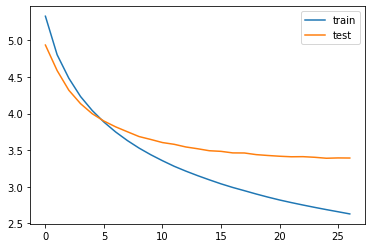

In [38]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 인퍼런스 모델

In [39]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음


In [40]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [41]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

=3


In [42]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

=3


## Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)

In [43]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

=3


In [44]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : former india captain ms dhoni was welcomed with slogans hailing former pakistani all rounder shahid afridi during his visit to jammu and kashmir locals chanted boom and also reportedly took name of militant dhoni who holds an honorary rank of lieutenant colonel in indian army was interacting with aspiring cricketers during an army organised event 
실제 요약 : fans chant afridi during dhoni kashmir visit 
예측 요약 :  dhoni visits ms dhoni for th time in kashmir


원문 : reacting to world number one tennis player rafael nadal jumping into roger federer's arms following team europe's victory in laver cup a user tweeted never thought i would see this image in my lifetime thank you other tweets read this is the best thing to ever happen in this universe and is everything thank you 2017 
실제 요약 : never thought would see this image in my lifetime tweets user 
예측 요약 :  federer tweets user on his th player win


원문 : the promotional video for oscars 2018 has been released the video references the be

예측 요약 :  sc rejects plea to ban evms in polls


원문 : actor rajkummar rao has revealed that he has faced many rejections sometimes because of his complexion and sometimes because of not being muscular enough it's not easy as many people come every day to mumbai to follow their passion i gave hundreds of auditions i have done many advertisements just to survive because mumbai is an expensive city he added 
실제 요약 : have faced rejection because of my reveals rao 
예측 요약 :  have no rao rao on rao rao


원문 : seven political parties sought registration from the election commission ec on tuesday ahead of the upcoming lok sabha elections the parties include the bhartiya dal united loktantrik jan swaraj party party and national united party notably as many as 22 political parties were registered by the election commission in november 2018 
실제 요약 : parties seek registration from election commission 
예측 요약 :  ec rejects poll party for polls in lok sabha polls


원문 : luxury jewellery brand tiffany c

예측 요약 :  england captain gets out of for st time in test


원문 : boxer shiva thapa won a silver medal at the asian boxing championships in uzbekistan on saturday becoming the first indian to claim three back to back medals at the event shiva lost the 60 kg final to second seed after defeating olympic medalist in the semi final on friday with the win shiva has qualified for the world championships 
실제 요약 : india shiva wins silver at asian boxing ships 
예측 요약 :  india wins silver at asian boxing championships


원문 : pornstar stormy daniels who claimed she had a sexual affair with us president donald trump in 2006 has been arrested at a strip club in ohio for letting a customer touch her while on stage in violation of state law however lawyer said the charge was politically motivated suggesting that the arrest was a pre planned sting operation 
실제 요약 : pornstar who accused trump of affair arrested at strip club 
예측 요약 :  pornstar trump lawyer arrested for trump affair


원문 : congress candi

## Step 5. Summa을 이용해서 추출적 요약해보기

추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높습니다.
반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮습니다.
Summa의 summarize를 사용하여 추출적 요약을 해보겠습니다.

In [45]:
from summa.summarizer import summarize
import urllib.request
import pandas as pd

urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

data['summary'] = data['text'].apply(lambda x: summarize(x, ratio=0.5))

data.sample(10)

,headlines,text,summary
49123,Govt investment in heavy industry firms halved...,"nIn the 2018 Budget, the government has halved...","nIn the 2018 Budget, the government has halved..."
45429,Oil was struck in Saudi Arabia for first time ...,Oil was struck for the first time in Saudi Ara...,The discovery transformed Saudi Arabia's econo...
31425,Thank you Cupid: Neha to Johar on her marriage...,Actress Neha Dhupia who recently got married t...,
87109,Vande Matram I am back: Abhijeet on joining Tw...,"Singer Abhijeet Bhattacharya, after his verifi...",
30114,Gayle walks for a duck despite umpire not givi...,Kings XI Punjab opener Chris Gayle walked afte...,The umpire deemed it as not out after CSK made...
73443,The Great Gatsby's mansion on sale for over Ã¢...,The mansion that inspired The Great Gatsby by ...,Fitzgerald spent time in the house with a frie...
15560,WhatsApp reportedly working to bring ads on iP...,Facebook-owned instant messaging service Whats...,Facebook-owned instant messaging service Whats...
56382,How do Electronic Voting Machines function?,Electronic Voting Machines (EVMs) in India con...,Electronic Voting Machines (EVMs) in India con...
64880,CIA retires bomb squad trainee dog for 'losing...,US' Central Intelligence Agency (CIA) has reti...,
33261,E-commerce sites to be held liable for false c...,E-commerce websites selling consumer goods wil...,E-commerce websites selling consumer goods wil...


In [46]:
# 실제 요약과 추출된 요약 비교
for i in range(50,100):
    print("원문 :", data['text'][i])
    print("실제 요약 :", data['headlines'][i])
    print("추출 요약 :", data['summary'][i])
    print("\n")

원문 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL). All agencies including regulators of the government have failed to track nefarious deals, he said. This comes after a media report on Tuesday accused DHFL's controlling shareholders of diverting funds to shell companies to buy assets.
실제 요약 : Yashwant Sinha demands probe into alleged fund diversion by DHFL
추출 요약 : Former Finance Minister Yashwant Sinha on Tuesday demanded a probe into the alleged diversion of loans worth Ã¢ÂÂ¹31,000 crore by Dewan Housing Finance (DHFL).


원문 : US-based Boeing on Wednesday reported annual sales worth $101.12 billion in 2018, the first time the planemaker's sales crossed the $100-billion mark in its 102-year history. The company said it expects to deliver between 895 and 905 commercial aircraft in 2019. Boeing retained its position as the world's largest planemaker for the seventh straight


---
## 회고
텍스트 전처리, rnn신경망, 어텐션 메커니즘을 사용한 seq2seq, Summa의 추출적 요약 등 자연어 학습에 대하여 전반적으로 알아보았습니다. 비슷한 방식으로 텍스트 번역과 같은 다른 분야에서도 사용될 수 있다는 점이 흥미로웠습니다. 하지만 직접 구현하였을 때의 학습결과가 미흡했습니다. 데이터 전처리부분이 조금 부족한 것이 원인인 것 같은데 학습하는데 시간이 너무 오래 걸려 여러가지 시도를 해보지 못하여 아쉬웠습니다.<br>
문법완성도 측면에서는 seq2seq을 사용한 추상적 모델이 조금 더 우수한 것 같고, 핵심단어 포함 측면으로는 Summa를 이용한 추출적 요약이 우수한 것 같습니다. 아무래도 Summa의 추출적요약은 문장 내의 단어들을 추출하여 그대로 사용하기 때문에 핵심 단어를 포함하게 되고 추상적 모델에서는 문자를 생성해 내기에 핵심 단어를 포함시키지 않는 경우가 생길 수 있습니다.